# RNN based Language Model

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import json

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['unsupervised']['text'][1]

'When I say this is my favourite film of all time, that comment is not to be taken lightly. I probably watch far too many films than is healthy for me, and have loved quite a few of them. I first saw "La Femme Nikita" nearly ten years ago, and it still manages to be my absolute favourite. Why?<br /><br />This is more than an incredibly stylish and sexy thriller. Luc Besson\'s great flair for impeccable direction, fashion, and appropriate usage of music makes this a very watchable film. But it is Anne Parillaud\'s perfect rendering of a complex character who transforms from a heartless killer into a compassionate, vibrant young woman that makes this film beautiful. I can\'t keep my eyes off of her when she is on screen.<br /><br />I have seen several of Luc Besson\'s films including "Subway", "The Professional", and the irritating "Fifth Element", and "Nikita" is without a doubt, far superior to any of these. Although this film has tragic elements, it is ultimately extremely hopeful. It

### Препроцессинг данных и создание словаря


In [ ]:
sentences = []
words = Counter()
word_threshold = 32


full_dataset = dataset['train']['text'] + dataset['test']['text'] + dataset['unsupervised']['text']

for feedback in tqdm(full_dataset):
    proccessed_feedback = feedback.replace("<br /><br />", " ")

    for sentence in sent_tokenize(proccessed_feedback):
        proccessed_sentence = sentence.lower()
        tokenized_sentence = word_tokenize(proccessed_sentence)

        if len(tokenized_sentence) <= word_threshold:
            sentences.append(proccessed_sentence)

        for word in tokenized_sentence:
            words[word] += 1

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 1025264


In [ ]:
# 20 самых часто используемых слов
[item[0] for item in words.most_common(20)]

['the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'this',
 'that',
 "'s",
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but']

In [ ]:
len(words)

230104

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab_size = 100000

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'] + [item[0] for item in words.most_common(vocab_size)])

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 100004


### Подготовка датасета

In [ ]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
# eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
#test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [ ]:
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch):
    losses = []
    perplexities = []
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses)/len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))

    return (losses, perplexities)

In [ ]:
def plot_statistics(info):
    '''
    Функция для вывода графиков
    info = {experimet_name: (losses, perplexities)}
    '''

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for (key, value), color in zip(info.items(), ['green', 'blue', 'red']):
        ax[0].plot(np.arange(len(value[0])), value[0], color=color, label=key)
        ax[0].set(title='Losses', xlabel='epoch')
        ax[1].plot(np.arange(len(value[1])), value[1], color=color)
        ax[1].set(title='Perplexities', xlabel='epoch')
    fig.legend()

### Первый эксперимент

Обучим три модели с разными RNN-блоками и сравним их качество.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size, rnn_type, rnn_layers, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == "RNN":
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=rnn_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=rnn_layers, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=rnn_layers, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type")

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
info = {}
for rnn_type in ["RNN", "GRU", "LSTM"]:
    print(f'\nОбучение {rnn_type}...\n')

    model = LanguageModel(hidden_dim=256, vocab_size=len(vocab),
                          rnn_type=rnn_type, rnn_layers=1, dropout_rate=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    info[rnn_type] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=10)

    with open(f'info.json', 'w') as f:
        json.dump(info, f)

Обучение RNN...


Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Обучение GRU...


Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Обучение LSTM...


Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

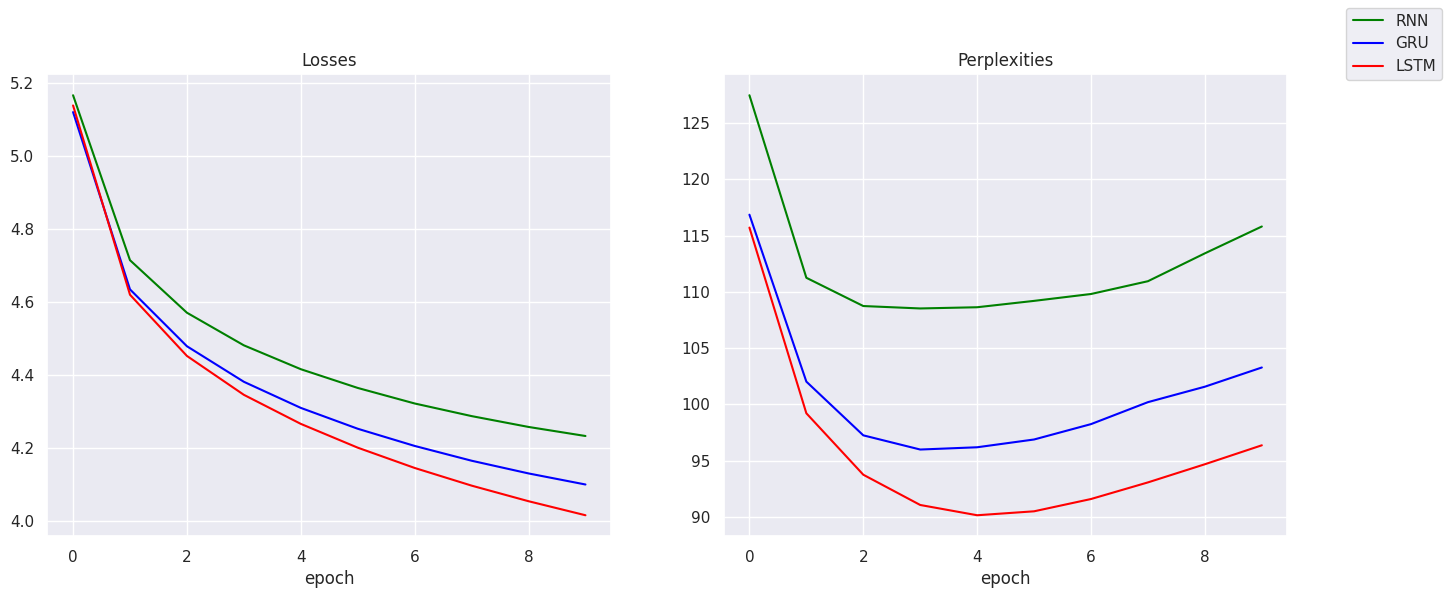

In [ ]:
plot_statistics(info)

Лучшее качество показывает LSTM. Также по графикам perplexities можно заметить, что модель переобучается.

### Второй эксперимент

Попробуем бороться с переобучением 2 способами: увеличим dropout_rate до 0.4, уменьшим learning_rate до 3e-4.

In [ ]:
info = {}

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab),
                        rnn_type='LSTM', rnn_layers=1, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

info['lr=3e-4'] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=10)

Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab),
                      rnn_type='LSTM', rnn_layers=1, dropout_rate=0.4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

info['dropout=0.4'] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=10)

Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

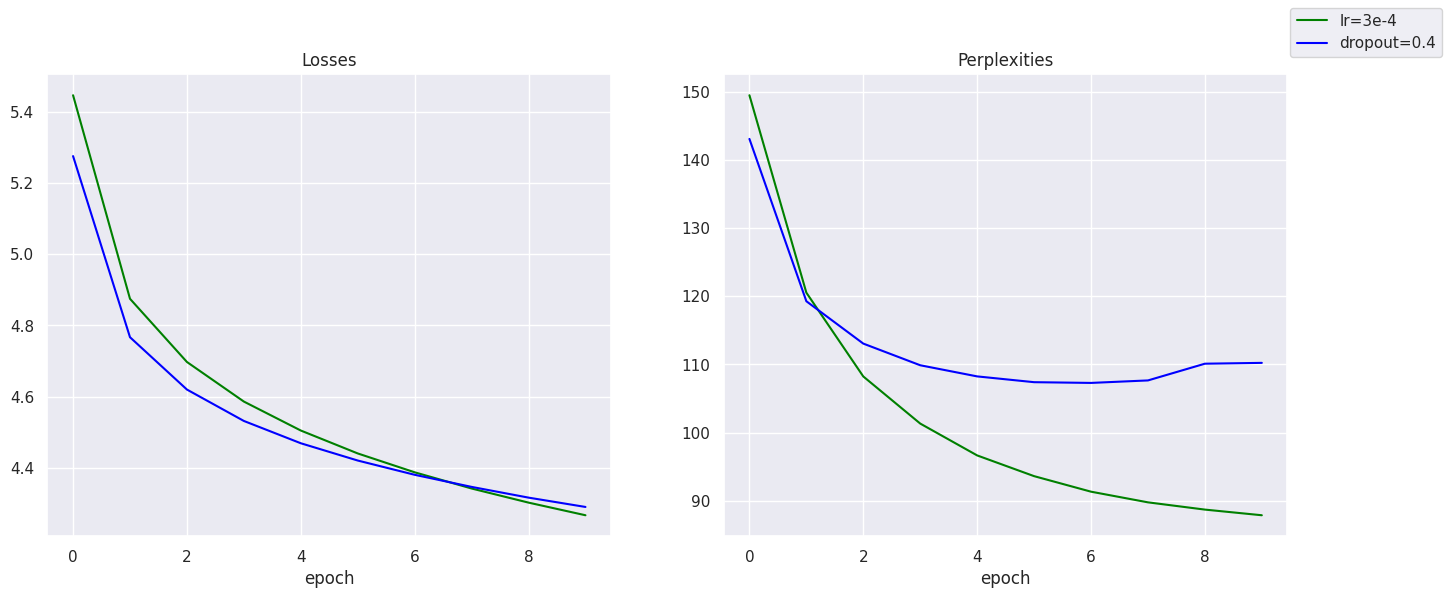

In [ ]:
plot_statistics(info)

Увеличение dropout_rate негативно сказывается на качестве модели, а уменьшение learning_rate позволяет избавиться от переобучения.

# Третий эксперимент

Попробуем увеличить количество слоев LSTM

In [ ]:
info = {}
for rnn_layers in [1, 2, 3]:
    print(f'\nОбучение LSTM c {rnn_layers} слоями...\n')

    model = LanguageModel(hidden_dim=256, vocab_size=len(vocab),
                          rnn_type='LSTM', rnn_layers=rnn_layers, dropout_rate=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    info[f'LSTM {rnn_layers} layer(s)'] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=10)


Обучение LSTM c 1 слоями...



Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]


Обучение LSTM c 2 слоями...



Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]


Обучение LSTM c 3 слоями...



Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

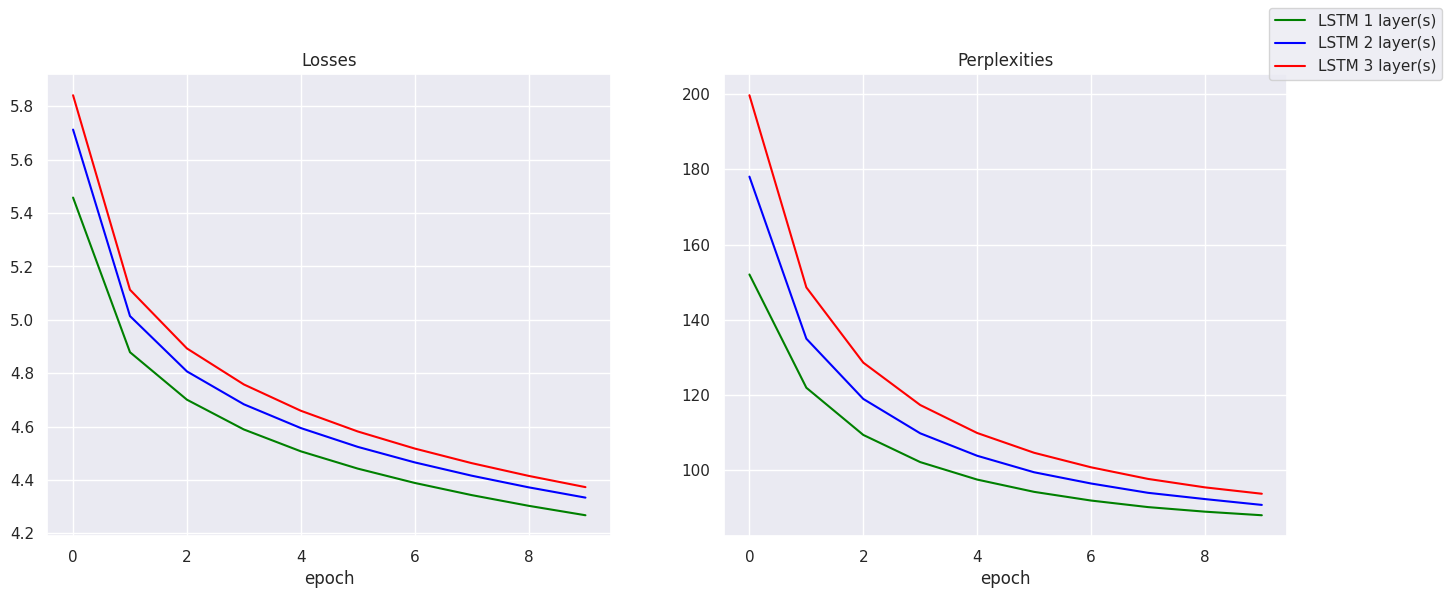

In [ ]:
plot_statistics(info)

Улучшений нет :(

# Четвертый эксперимент

Изменим размерность эмбеддингов.

In [ ]:
with open('/content/info_hidden_dim.json', 'r') as f:
    info = json.load(f)

model = LanguageModel(hidden_dim=1024, vocab_size=len(vocab),
                      rnn_type='LSTM', rnn_layers=1, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

info['hidden_dim=1024'] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=10)

with open('/content/info_hidden_dim_final.json', 'w') as f:
    json.dump(info, f)

Training epoch 0:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3204 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/801 [00:00<?, ?it/s]

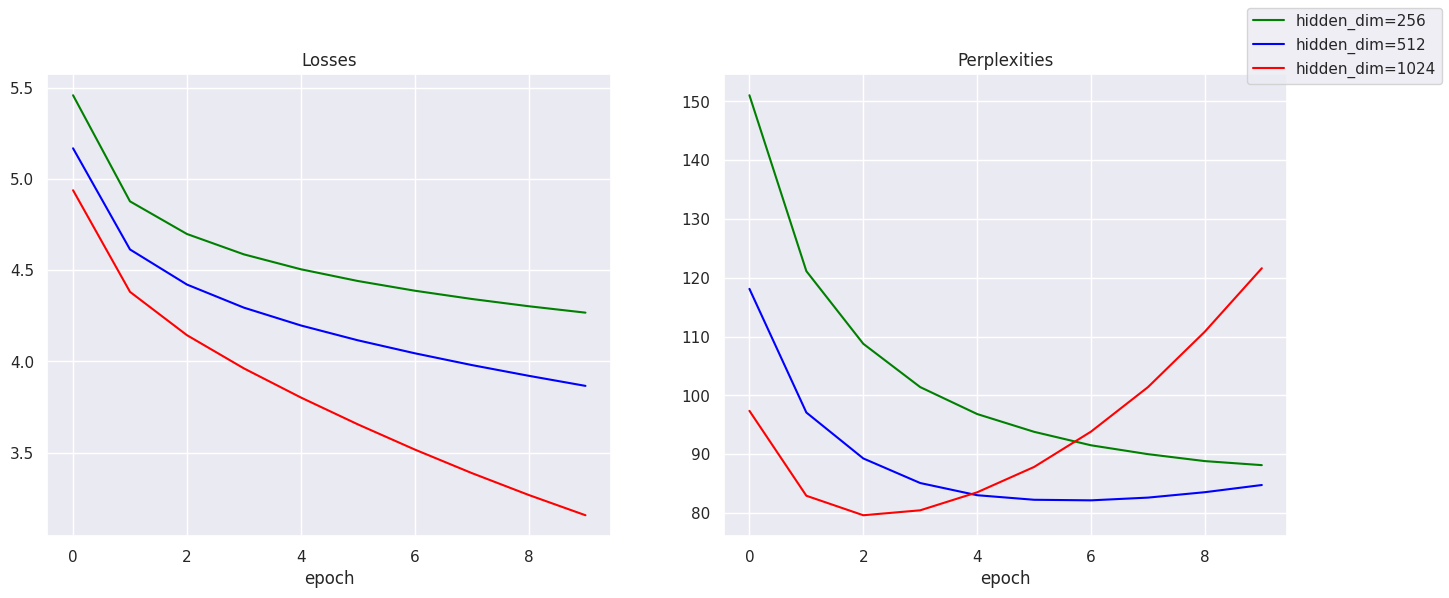

In [ ]:
plot_statistics(info)

Больше размерность эмбеддингов - выше качество. Но, с другой стороны, у модели становится больше обучаемых параметров, поэтому она быстрее переобучается.

# Финальная модель

*   LSTM с 1 слоем
*   learning_rate=1e-4
*   hidden_dim=1024
*   ограничение обучения (ранняя остановка против переобучения)


In [ ]:
# немного изменим функцию train, чтобы сохранять веса модели
from google.colab import files

def train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch):
    losses = []
    perplexities = []
    for epoch in range(1, num_epoch+1):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        l = sum(epoch_losses)/len(epoch_losses)
        p = evaluate(model, criterion, eval_dataloader)
        losses.append(l)
        perplexities.append(p)
        print(f'loss={l}\nperplexity={p}')

        if len(perplexities) >= 2:
            if perplexities[-1] >= perplexities[epoch - 1]:
                break

    return (losses, perplexities)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
info = {}
model = LanguageModel(hidden_dim=1024, vocab_size=len(vocab),
                      rnn_type='LSTM', rnn_layers=1, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

info['final_model'] = train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=3)

Training epoch 1:   0%|          | 0/6408 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1602 [00:00<?, ?it/s]

loss=4.730069742295031
perplexity=83.63408167263988


Training epoch 2:   0%|          | 0/6408 [00:00<?, ?it/s]

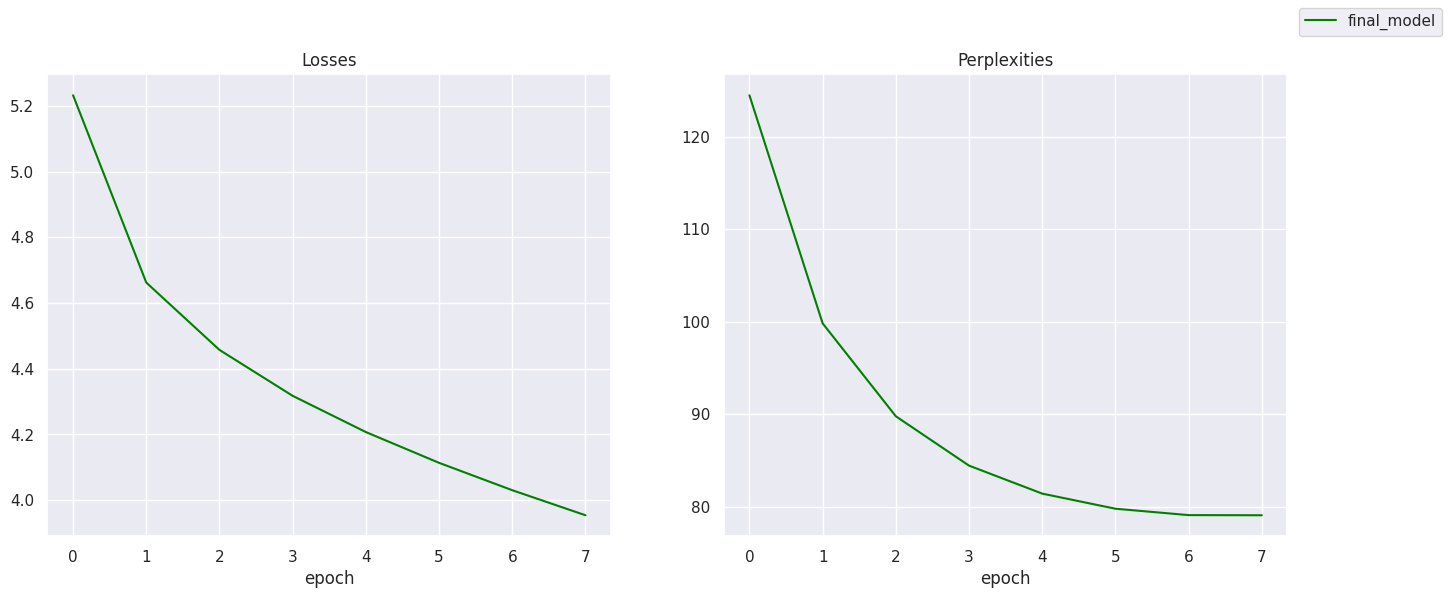

In [ ]:
plot_statistics(info)

In [ ]:
torch.save(model.state_dict(), 'weights_final.pth')
torch.save(optimizer.state_dict(), 'optimizer_final.pth')

In [ ]:
files.download('weights_final.pth')
files.download('optimizer_final.pth')

In [ ]:
plot_statistics(info)

# Непосредственно генерация

In [ ]:
def greed_generation(model, init_seq="", max_seq_len=128):
    model = model.to('cpu')
    input_ids = [word2ind['<bos>']]
    input_ids += [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(init_seq)]
    input_ids = torch.LongTensor(input_ids).to('cpu')

    model.eval()
    with torch.no_grad():
        for _ in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    out_seq = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return out_seq

In [ ]:
init_seqs = ["",
             "this movie is great, but",
             "my favourite film is",
             "i hate",
             "luc besson",
             "russian films are",
             "i just want to"]

for init_seq in init_seqs:
    out_seq = greed_generation(model, init_seq)
    print(f'init_seq: {init_seq}\nout_seq: {out_seq}\n')

init_seq: 
out_seq: <bos> the film is a bit of a letdown , but it 's not a good movie . <eos>

init_seq: this movie is great, but
out_seq: <bos> this movie is great , but it 's not a good movie . <eos>

init_seq: my favourite film is
out_seq: <bos> my favourite film is the <unk> of the <unk> ' . <eos>

init_seq: i hate
out_seq: <bos> i hate this movie . <eos>

init_seq: luc besson
out_seq: <bos> luc besson 's character is a bit too much for her . <eos>

init_seq: russian films are
out_seq: <bos> russian films are a lot better than this . <eos>

init_seq: i just want to
out_seq: <bos> i just want to say that this movie is a great example of the genre . <eos>



<b/>Проведенные эксперименты: (значение перплексий для каждого эксперимента представлены на графиках)</b>

1.   Произведено сравнение различных RNN-блоков: vanilla RNN, GRU и LSTM. Лучшее качество показала LSTM.
2.   Увеличение вероятности дропаута привело к ухудшению работы модели, а уменьшение learning rate позволило добиться лучшей сходимости.
3.   Протестированы LSTM с различным количеством слоев: 1, 2 и 3, однако перформанс модели это не улучшило. Наименьшую перплексию показала однослойная модель.
4.  Увеличение размерности эмбеддингов помогло добиться меньшей перплексии, hidden_dim увеличен до 1024.

<b/>Идеи по улучшению качества:</b>

Здесь все просто - увеличиваем размер обучающей выборки и размер словаря (понятно, что увеличение размера словаря приведет к уменьшению перплексии, но качество генерации текста будет гораздо лучше).

